In [2]:
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline

In [4]:
with h5py.File("DESIJ1537+1443_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

image_data = kwargs_data["image_data"]


with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf["psf_type"] = "PIXEL"

C:\Users\HTCM\AppData\Local\Temp\ipykernel_108\1365966619.py:1: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix');


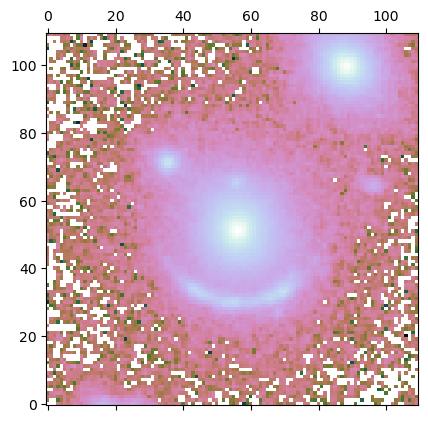

In [5]:
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix");

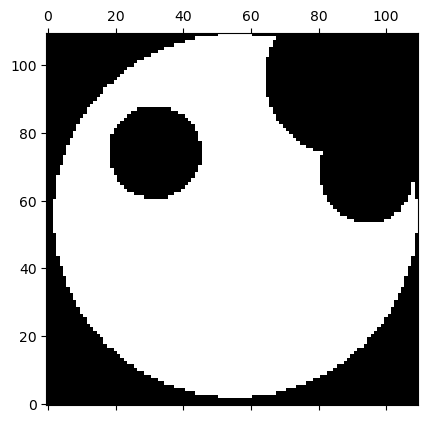

C:\Users\HTCM\AppData\Local\Temp\ipykernel_108\3742384727.py:66: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(masked_image_data),
C:\Users\HTCM\AppData\Local\Temp\ipykernel_108\3742384727.py:66: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(masked_image_data),


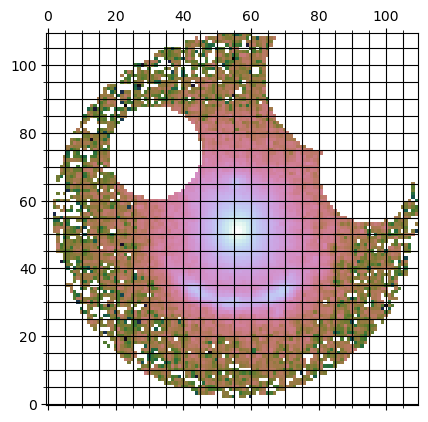

In [34]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)


r = 4.3  # In Arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra + 0,
    lens_center_dec + 0,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.6,
    lens_center_dec + 3.3,
    1.9,
    1.9,
    6,
)


mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.1,
    lens_center_dec + 1,
    1.1,
    1.2,
    6,
)


mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.9,
    lens_center_dec + 1.5,
    1.1,
    1.1,
    1,
)


mask = (1 - mask_outer) * (1 - mask_ext_1) * (1 - mask_ext_2) * (1 - mask_ext_3)

mask[mask >= 1] = 1
mask[mask < 0] = 0

mask = mask.reshape(num_pix, num_pix)

plt.matshow(mask, origin="lower", cmap="cubehelix")
plt.show()

# Masking Image Data
masked_image_data = np.multiply(image_data, mask)

plt.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
plt.grid(which="both", color="black")
plt.minorticks_on()
plt.grid(which="minor", color="black")
plt.show()

In [35]:
lens_model_list = ["EPL", "SHEAR"]

source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]

lens_light_model_list = ["SERSIC_ELLIPSE"]

In [36]:
# Lens Galaxy's Mass Model

fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})
fixed_lens.append({"ra_0": 0, "dec_0": 0})

kwargs_lens_init.append(
    {
        "theta_E": 1.0,
        "gamma": 2.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
    }
)

kwargs_lens_init.append({"gamma1": 0.0, "gamma2": 0.0})


kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)

kwargs_lens_sigma.append({"gamma1": 0.1, "gamma2": 0.1})

kwargs_lower_lens.append(
    {
        "theta_E": 0.01,
        "gamma": 1.0,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)

kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})

kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

# Lens Galaxy's Light Model

fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({"n_sersic": 4.0})


kwargs_lens_light_init.append(
    {
        "R_sersic": 0.5,
        "n_sersic": 2,
        "e1": 0,
        "e2": 0,
        "center_x": 0.0,
        "center_y": 0,
        "amp": 16,
    }
)

kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)


kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)

kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


joint_lens_with_light = [[0, 0, ["center_x", "center_y", "e1", "e2"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]


# Source Galaxy's Light Model

fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


fixed_source.append({"n_sersic": 1.0})
fixed_source.append({"n_max": 6})

kwargs_source_init.append(
    {
        "R_sersic": 0.2,
        "n_sersic": 1,
        "e1": 0,
        "e2": 0,
        "center_x": 0.0,
        "center_y": 0,
        "amp": 16,
    }
)

kwargs_source_init.append({"beta": 3, "center_x": 0, "center_y": 0})


kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.1,
        "e1": 0.08,
        "e2": 0.07,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
)

kwargs_source_sigma.append({"beta": 2, "center_x": 0.2, "center_y": 0.2})


kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)

kwargs_lower_source.append({"beta": 0, "center_x": -10, "center_y": -10})

kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

kwargs_upper_source.append({"beta": 5, "center_x": 10, "center_y": 10})


joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]


# Combining Everything in `kwargs_params` Dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}


kwargs_constraints = {
    "joint_lens_with_light": joint_lens_with_light,
    "joint_source_with_source": joint_source_with_source,
}

In [37]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask]}


kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

In [38]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}


multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]


kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

In [39]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}


multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]


kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

In [40]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)


fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 200, "n_iterations": 100}],
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.9817687234115713 reduced X^2 of best position
-3483.315430664255 log likelihood
7096 effective number of data points
[{'theta_E': 1.5306519723667196, 'gamma': 1.7732913996740844, 'e1': -0.06590096367435329, 'e2': 0.03504945154891227, 'center_x': -0.068204229634661, 'center_y': -0.34252856175819085}, {'gamma1': 0.03133104891683732, 'gamma2': 0.012320039233266696, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.296122633662254, 'n_sersic': 1.0, 'e1': 0.24516044917534344, 'e2': 0.1558720590885794, 'center_x': -0.08590274808529384, 'center_y': -0.6065315792194168}, {'amp': 1, 'n_max': 6, 'beta': 0.024826009725641297, 'center_x': -0.08590274808529384, 'center_y': -0.6065315792194168}] source result
[{'amp': 1, 'R_sersic': 0.6598982173995388, 'n_sersic': 4.0, 'e1': -0.06590096367435329, 'e2': 0.03504945154891227, 'center_x': -0.068204229634661, 'center_y': -0.34252856175819085}] lens light 

In [41]:
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed()

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "./DESIJ1537+1443_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

-0.9755819718986851 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9755819718986846


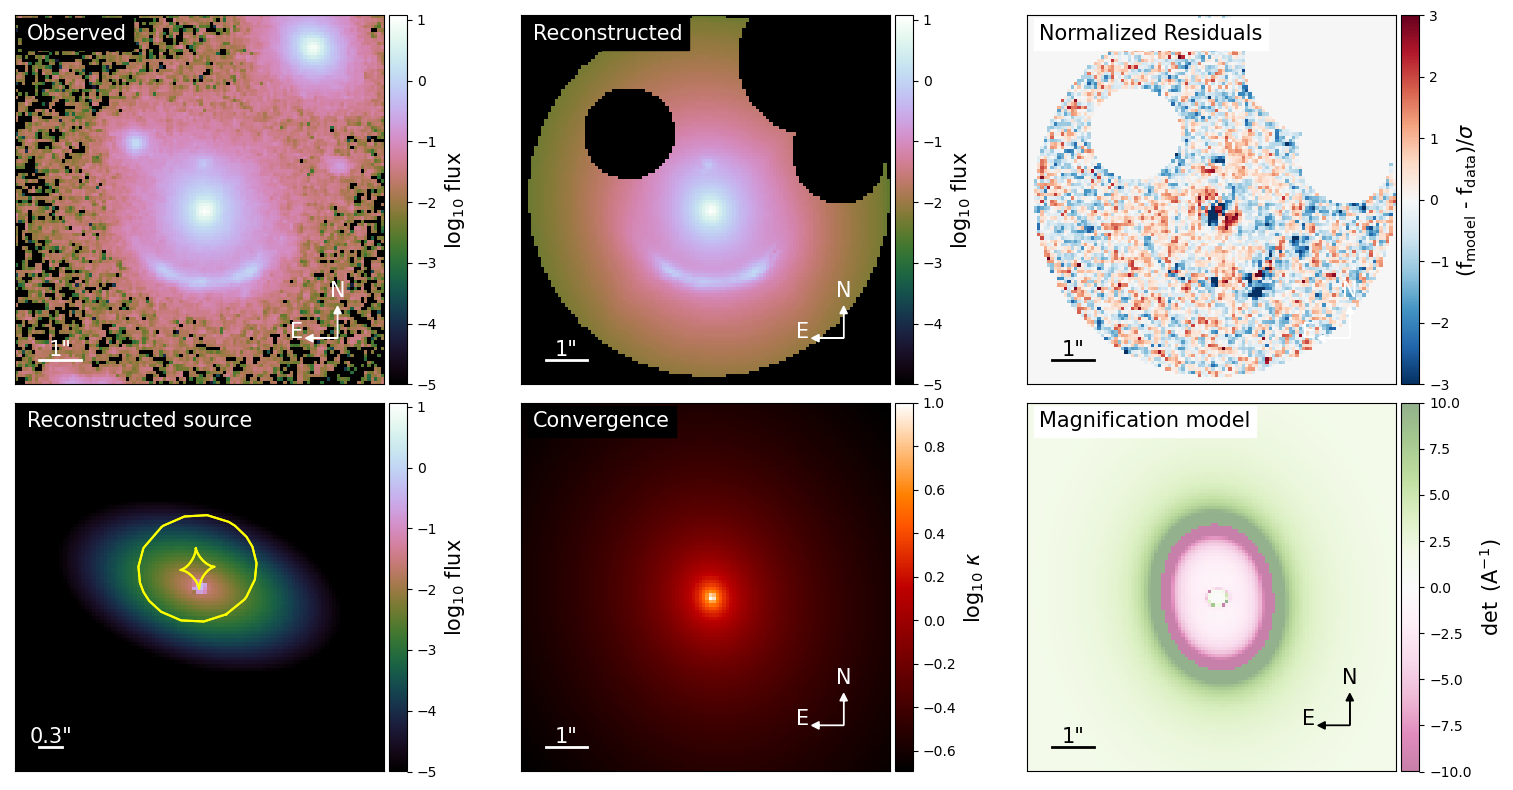

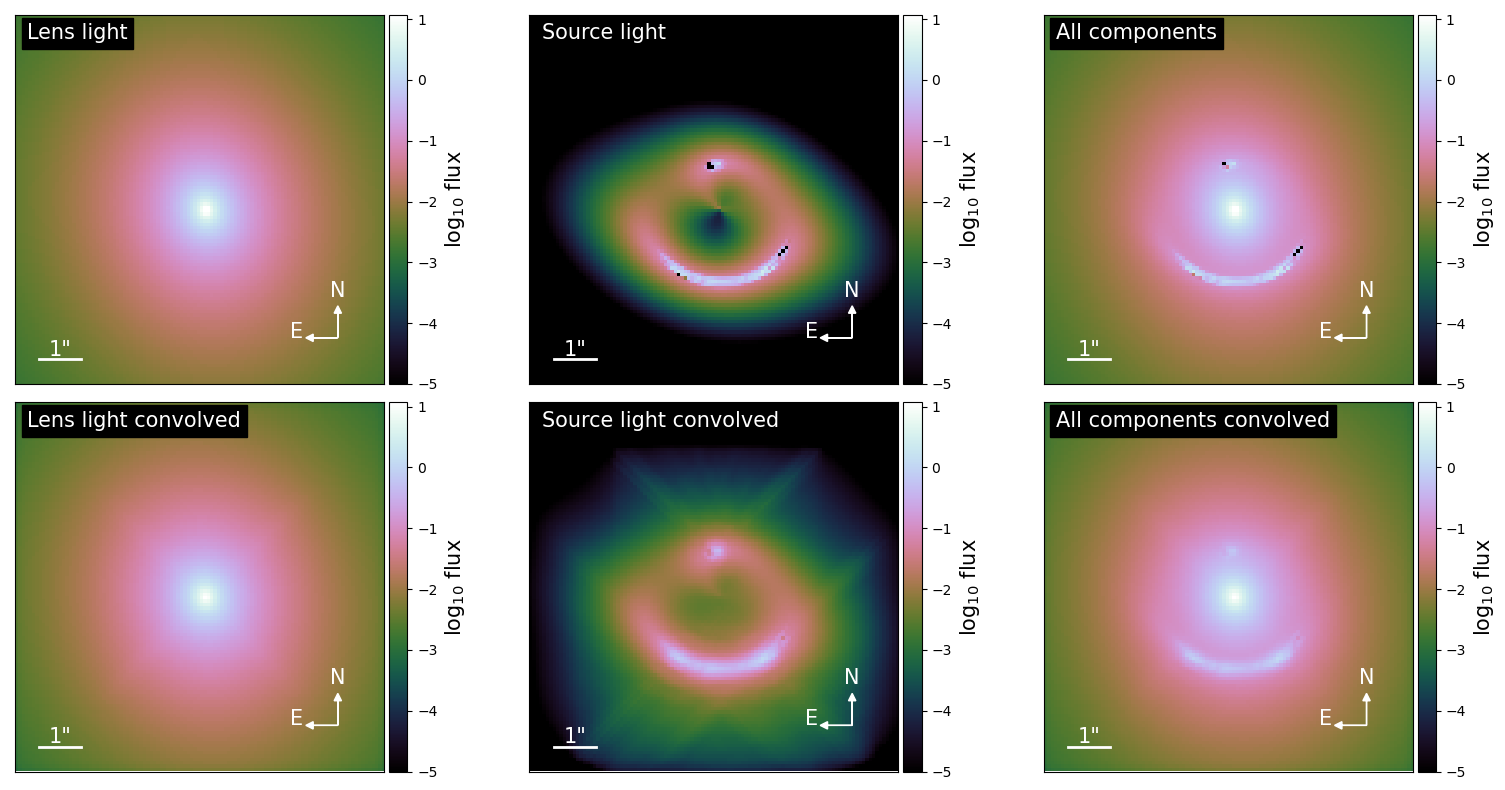

{'kwargs_lens': [{'theta_E': 1.5306519723667196, 'gamma': 1.7732913996740844, 'e1': -0.06590096367435329, 'e2': 0.03504945154891227, 'center_x': -0.068204229634661, 'center_y': -0.34252856175819085}, {'gamma1': 0.03133104891683732, 'gamma2': 0.012320039233266696, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 3.1534317010715456, 'R_sersic': 0.296122633662254, 'n_sersic': 1.0, 'e1': 0.24516044917534344, 'e2': 0.1558720590885794, 'center_x': -0.08590274808529384, 'center_y': -0.6065315792194168}, {'amp': array([ 542.7240105 ,   38.45852992,  -18.8579644 ,  136.09297827,
         46.15643023,  113.17577252,  379.71997205, -104.78366543,
        -85.3851141 , -107.21043908,  -63.93586265,  -48.67491453,
        122.77824339,  215.50745172,  128.03085876, -129.92963521,
        -32.45254123, -224.36122172, -189.50803011,  -16.1449233 ,
         27.57667324,  153.44054612,  -15.44368155,  101.45116075,
        240.83239606,   44.67883281,  -44.74619265,   57.58464004]), 'n_max': 6, 'beta

In [42]:
modelPlot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
    linear_solver=kwargs_constraints.get("linear_solver", True),
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0, 0])

modelPlot.model_plot(ax=axes[0, 1])

modelPlot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")

modelPlot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.05, numPix=100, with_caustics=True, scale_size=0.3
)

modelPlot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")

modelPlot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()

f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)

plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)

modelPlot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)

modelPlot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)

modelPlot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)

modelPlot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)

modelPlot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()

f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)

plt.show()
print(kwargs_result)